<a href="https://colab.research.google.com/github/arka57/Potato-Disease-Classification/blob/main/Potato_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import torchvision
import torchvision.models as models

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
cd MyDrive

/gdrive/MyDrive


In [ ]:
pwd

'/gdrive/MyDrive'

In [ ]:
#Data PreProcessing

In [ ]:
transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
#Loading the dataset 

In [ ]:
full_data = tv.datasets.ImageFolder(root="Potato_Disease_Classification",transform=transform)

In [ ]:
#Displaying one particular potato leaf image

In [ ]:
image,label=full_data[0]

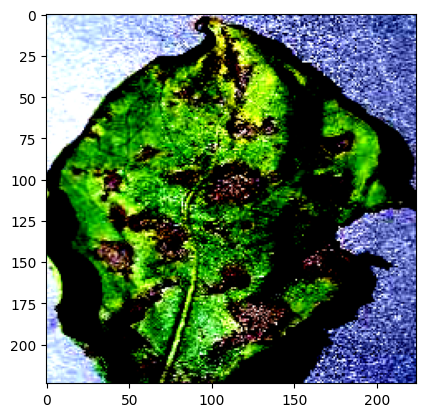

In [ ]:
image=image.detach().numpy()
image=np.transpose(image,(1,2,0))
#plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [ ]:
print(label)

0


In [ ]:
#No of classes

In [ ]:
d=full_data.classes

In [ ]:
d[0]

'Potato___Early_blight'

In [ ]:
d

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

In [ ]:
full_data

Dataset ImageFolder
    Number of datapoints: 2152
    Root location: Potato_Disease_Classification
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
#Splitting the dataset into train,test and validation

In [ ]:
train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size
val_size=int(0.5*test_size)
test_size=test_size-val_size

In [ ]:
train_data, test_data,validation_data = random_split(full_data, [train_size, test_size,val_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

In [ ]:
#Defining the model

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.cnn=nn.Sequential(
            nn.Conv2d(3,6,(5,5)),
            nn.AvgPool2d(2,stride=2),
            nn.ReLU(),
            nn.Conv2d(6,16,(5,5)),
            nn.AvgPool2d(2,stride=2),
            nn.ReLU(),
            nn.Conv2d(16,8,(5,5)),
            nn.AvgPool2d(2,stride=2),
            nn.ReLU(),
            nn.Conv2d(8,4,(5,5)),
            nn.AvgPool2d(2,stride=2),
            nn.ReLU()

        )
        self.fc=nn.Sequential(
            
            nn.Linear(400,200),

            nn.ReLU(),
            nn.Linear(200,80),
            nn.ReLU(),
            nn.Linear(80,3)
        )
    def forward(self,x):
        #print(x.shape)
        x=self.cnn(x)
        #print(x.shape)
        #print(x.size(0))
        x=x.view(x.size(0),-1)
        #print(x.shape)
        x=self.fc(x)
        #print(x.shape)
        return x



In [ ]:
#Instantiating network and other necessities
     

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
net=LeNet()
net.to(device)
opt=optim.Adam(net.parameters(),weight_decay=0.01)
loss_fn=nn.CrossEntropyLoss()
     


In [ ]:
#Evaluation


In [ ]:
def evaluation(dataloader):
    total=0
    correct=0
    for data in dataloader:
        input,label=data
        input,label = input.to(device), label.to(device)
        output=net.forward(input)
        _,pred=torch.max(output,1)
        total+=label.size(0)
        correct+=(pred==label).sum().item()
    return (correct/total)*100    

In [ ]:
#Learning algo

In [ ]:
epoch=30

In [ ]:
%%time

min_loss=1000
loss_epoch=[]
train_accuracy_epoch=[]
validation_accuracy_epoch=[]
for i in range(0,epoch):
    for j,data in enumerate(train_loader,0):
        input,label=data
        input,label = input.to(device), label.to(device)
        
        output=net(input)
        
        loss=loss_fn(output,label)
        loss.backward()
        opt.step()
        opt.zero_grad()

        del input, label, output
        torch.cuda.empty_cache()

        if(loss<min_loss):
            min_loss=loss
            best_model=copy.deepcopy(net.state_dict())

    loss_epoch.append(loss.item())
    x=evaluation(train_loader)
    y=evaluation(validation_loader)
    print('Epoch %d/%d ,Training accuracy %0.2f,Validation Accuracy %0.2f' %(i,epoch,x,y))
    train_accuracy_epoch.append(x)
    validation_accuracy_epoch.append(y)
plt.plot(loss_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()  




torch.Size([32, 3, 224, 224])
torch.Size([32, 4, 10, 10])
32
torch.Size([32, 400])
torch.Size([32, 3])
torch.Size([32, 3, 224, 224])
torch.Size([32, 4, 10, 10])
32
torch.Size([32, 400])
torch.Size([32, 3])
torch.Size([32, 3, 224, 224])
torch.Size([32, 4, 10, 10])
32
torch.Size([32, 400])
torch.Size([32, 3])
torch.Size([32, 3, 224, 224])
torch.Size([32, 4, 10, 10])
32
torch.Size([32, 400])
torch.Size([32, 3])
torch.Size([32, 3, 224, 224])
torch.Size([32, 4, 10, 10])
32
torch.Size([32, 400])
torch.Size([32, 3])
torch.Size([32, 3, 224, 224])
torch.Size([32, 4, 10, 10])
32
torch.Size([32, 400])
torch.Size([32, 3])
torch.Size([32, 3, 224, 224])
torch.Size([32, 4, 10, 10])
32
torch.Size([32, 400])
torch.Size([32, 3])
torch.Size([32, 3, 224, 224])
torch.Size([32, 4, 10, 10])
32
torch.Size([32, 400])
torch.Size([32, 3])
torch.Size([32, 3, 224, 224])
torch.Size([32, 4, 10, 10])
32
torch.Size([32, 400])
torch.Size([32, 3])
torch.Size([32, 3, 224, 224])
torch.Size([32, 4, 10, 10])
32
torch.Size([

KeyboardInterrupt: ignored

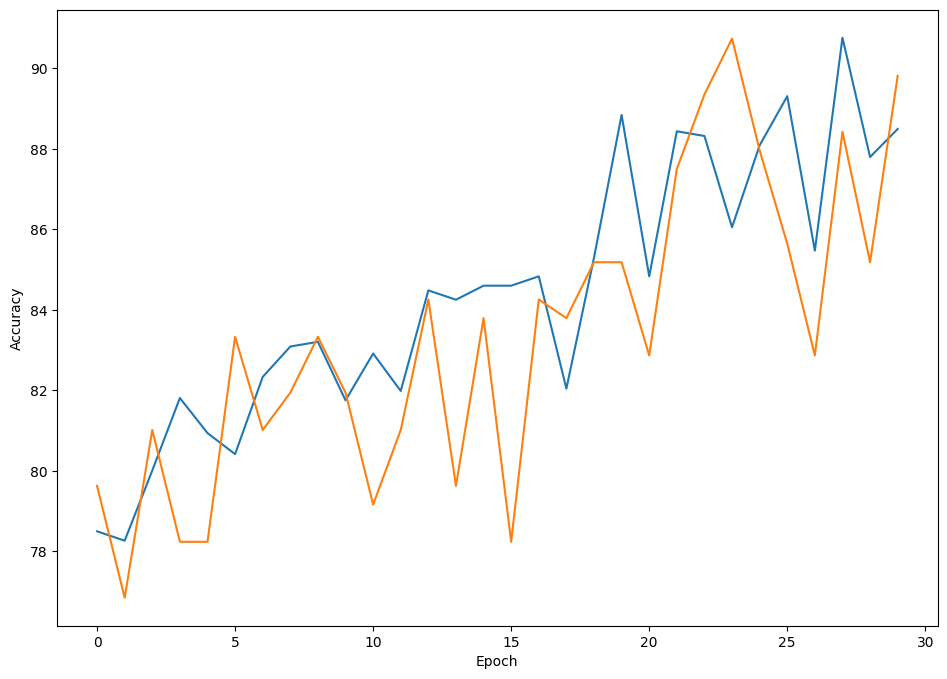

In [ ]:
plt.figure(figsize=(25, 8))
plt.subplot(1,2,1)
plt.plot(range(30),train_accuracy_epoch,label="Train Accuracy",label=Training Accuracy)
plt.plot(range(30),validation_accuracy_epoch,label="Validation Accuracy",label=Validation Accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
#Best Accuracy of 90% is achieved

In [ ]:
best_model

In [ ]:
#Saving the  model

In [ ]:
torch.save(net.state_dict(), "model1.th")

In [ ]:
#Loading the model

In [ ]:
loaded_model=LeNet()

loaded_model.load_state_dict(torch.load("model1.th"))
loaded_model.to(device)
loaded_model.eval()


LeNet(
  (cnn): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): ReLU()
    (6): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1))
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): ReLU()
    (9): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1))
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=80, bias=True)
    (3): ReLU()
    (4): Linear(in_features=80, out_features=3, bias=True)
  )
)

In [ ]:
for p in loaded_model.parameters():
    print(p)

In [ ]:
#Testing our model on a data (Prediction of an given image on the bulit model)

(3, 224, 224)
(224, 224, 3)


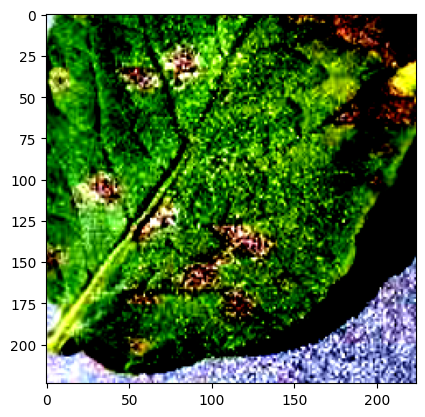

tensor(0, device='cuda:0')
Potato___Early_blight
tensor(0, device='cuda:0')
Potato___Early_blight


In [ ]:
for i in test_loader:

    input,label=i
    input,label = input.to(device), label.to(device)
    img1=input[0]
    label1=label[0]
    output=loaded_model.forward(input)
    _,predicted_class_label=torch.max(output,1)
    predicted_label=predicted_class_label[0]
    break
npimg1=img1.detach().cpu().numpy()
print(npimg1.shape)
npimg1=np.transpose(npimg1,(1,2,0))
print(npimg1.shape)
plt.imshow(npimg1)
plt.show()
print(label1)
print(d[label1])
print(predicted_label)
print(d[predicted_label])

In [ ]:
loaded_model=LeNet()
loaded_model.load_state_dict(best_model)
loaded_model.to(device)
loaded_model.eval()

LeNet(
  (cnn): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): ReLU()
    (6): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1))
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): ReLU()
    (9): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1))
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=80, bias=True)
    (3): ReLU()
    (4): Linear(in_features=80, out_features=3, bias=True)
  )
)

(3, 224, 224)
(224, 224, 3)


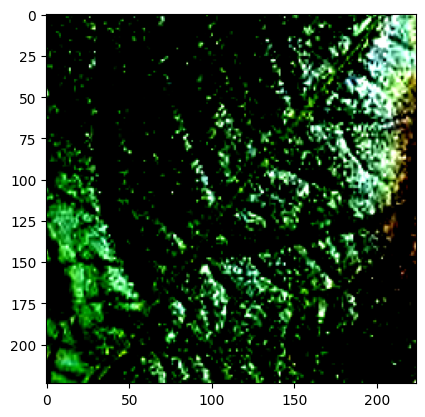

tensor(1, device='cuda:0')
Actual Label: Potato___Late_blight
tensor(1, device='cuda:0')
Predicted Label: Potato___Late_blight
tensor(1, device='cuda:0')


In [ ]:
for i in test_loader:

    input,label=i
    input,label = input.to(device), label.to(device)
    img1=input[0]
    label1=label[0]
    output=loaded_model.forward(input)
    _,predicted_class_label=torch.max(output,1)
    predicted_label=predicted_class_label[0]
    break
npimg1=img1.detach().cpu().numpy()
print(npimg1.shape)
npimg1=np.transpose(npimg1,(1,2,0))
print(npimg1.shape)
plt.imshow(npimg1)
plt.show()
print(label1)
print("Actual Label:",d[label1])
print(label1)

print("Predicted Label:",d[predicted_label])
print(predicted_label)